In [80]:
import pandas as pd
import numpy as np

from cleantext import clean
import re
import nltk 
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import matplotlib.pyplot as plt 
import seaborn as sns

import tensorflow as tf
from keras.preprocessing.text import text_to_word_sequence

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.naive_bayes import ComplementNB, MultinomialNB


from wordcloud import WordCloud

import joblib 




### Reading file

In [2]:
df = pd.read_csv("news_cleaned_2018_02_13.csv", nrows = 50000, skiprows=lambda x: x in range(1, 400000),usecols=["type", "content"])

In [3]:
def clean_file(df:pd.DataFrame) -> (pd.DataFrame, str):
    """
        Takes a TextFileReader with dataframes, and cleans the content. 
        
        Returns the new TextFileReader with cleaned content, and a concatenated string of all the contents. 
    """
    concat_text = ""
    i = 0
    for text in df["content"]:
        if type(text) == str:
            date_reg = re.compile("\d{0,4}-\d{0,2}-\d{0,2}[^,]+") # Cleaning the Dates of the text
            date_subbed = date_reg.sub("<DAT>", text)
            date_reg2 = re.compile("/^(?:\d{4})-(?:\d{2})-(?:\d{2})T(?:\d{2}):(?:\d{2}):(?:\d{2}(?:\.\d*)?)(?:(?:-(?:\d{2}):(?:\d{2})|Z)?)$/")
            date_subbed2 = date_reg2.sub("<DAT>", date_subbed)
            cleaned_news_file = clean(date_subbed2,no_line_breaks=True, # Cleaning the rest of the text.
                    no_urls=True,                  
                    no_emails=True,                   
                    no_numbers=True,
                    no_punct=False,
                    replace_with_number = "<NUM>")
            df.loc[i,"content"] = cleaned_news_file # returning the cleaned text to the right position in our dataframe
            
            concat_text = concat_text + cleaned_news_file # Making a string with all the content.
        else:
            pass 
        i += 1
    return df, concat_text

### Cleaning the file

In [4]:
df, news_file  = clean_file(df)

### Dropping the articles with types of "unknown" or NaN

In [5]:
## Dropping the "unknown" and nan types. 

a = ['rumor', 'hate', 'unreliable', 'conspiracy', 'clickbait', 'satire',
       'fake', 'reliable', 'bias', 'political', 'junksci']



df = df[df["type"].isin(a)]

### Dropping duplicate rows

In [6]:
## Dropping duplicate columns
     
df.drop_duplicates("content",inplace=True) 

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26737 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   type     26737 non-null  object
 1   content  26737 non-null  object
dtypes: object(2)
memory usage: 626.6+ KB


In [8]:
def tokenize(text):
    """
    Takes a string of text and tokenizes it. 
    
    Returns a list of the tokenized text. 
    
    """
    token_list = text_to_word_sequence(text)
    words = [word for word in token_list if word.isalpha()]
    return words 
    


In [9]:
def removing_stopwords(token_list:list) -> list:
    """
    Takes a list of words and removes the stopwords 
    
    Returns a list of words
    """
    stop_words = set(stopwords.words('english'))
    words = [w for w in token_list if not w in stop_words]
    return words

In [10]:
def stemming(token_list:list) -> list:
    """
    Takes a list of words and stems the words
    
    Returns a list of stemmed words. 
    """
    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in token_list]
    return stemmed 
    

In [11]:
def unique(list1):
    """
    Takes a list and drop all duplicates in the list
    
    Returns a list with no duplicates
    """
    unique_list = pd.Series(list1).drop_duplicates().tolist()
    return unique_list

### Inserting labels true or false for the article dependent on their types

In [12]:
## Making the labels for the articles. 

df_labels = df["type"].isin(["political", "reliable" , "clickbait"])

In [13]:
## Inserting the labels in the original Dataframe.

df.insert(loc = len(df.columns) , column = "label" ,value = df_labels)                              

### Removing stopwords and stemming of the content in each article.

In [14]:
## Stemming and removing stopwords of the documents. 

df["content"] = df["content"].apply(tokenize)
df["content"] = df["content"].apply(removing_stopwords)
df["content"] = df["content"].apply(stemming)

df["content"] = df["content"].apply(" ".join)

# Part 2 Feature enginering


#### Splitting the data into training, validation and test sets. 

First we want to figure out which labels we want to give to our articles. Using our dataset and the README documentation of the FakeNewsCorp Dataset we see that we have 11 (13 with nan and unknown) different types of articles.

We want to transform this into labels of either fake or reliable.
Fake and Satire types are obviosly fake, and reliable and political are as reliable as it gets with news. 

Now to label the rest is a bit more subjective. We have chosen to label clickbait as reliable, as the content itself is probably fine, but the headlines are the questional part. 

Conspiracy, bias and junksci kinda falls under the same category of not necessarily being fake, but is in the extreme end of opinion to the point most of it probably is fake. 
Although it is good to note that a lot of modern science was also "fake", before it became science. See for example germs. And just straight up dismissing everything that isn't established "truth" can also be dangerous. With that said we chose to label these three types as fake. 

Unreliable as the name suggests is unreliable. From the description on the README, it might be true but it needs more verification. Here it would be nice to have more classes than just reliable and fake so something that are very much in the middle could have a class to go to. 
For simplecity reasons we gave unreliable the label fake. 

The hate type is very difficult to place, because it's again not necessarily fake news, but at the same time it smells of extremist propaganda, and that tends to be more fake than true, or at least distorted in such a way that the "meat" isnt wrong per say but the conclusion is false. 
In the end classifying such news as fake is probably better from an ethical point of view, so we dont give legitimacy to rasicm, hate and other forms of discrimination. 

We are left with rumor, nan and unknown. 
Rumor is not described in the README, but since its a rumor it should probably be treated with caution until the rumor is confirmed either true or false. So we will label this as fake. 

We have removed nan and unknown from the dataset, since it doesnt really make sense to label it. We could have also just labeled it fake, and since its a very small percentage of the dataset the difference is probably not that big. 



### Splitting the dataset

In [15]:
X_train_temp, X_val, y_train_temp, y_val  = train_test_split(df, df_labels, test_size = 0.1, random_state=0) 
X_train, X_test, y_train, y_test = train_test_split(X_train_temp, y_train_temp, test_size = 1/9, random_state=0)

### Making the bag of words matrix. We are using the 1000 most frequent words in the corpus.

In [16]:
bow_vectorizer = CountVectorizer(min_df=5)

bow_vectorizer.fit(df["content"])
X_train_bow = bow_vectorizer.transform(X_train["content"])
X_val_bow = bow_vectorizer.transform(X_val["content"])
X_test_bow = bow_vectorizer.transform(X_test["content"])



### Making a TF-IDF Unigram feature.

In [17]:
unigram_vectorizer = TfidfVectorizer(max_features=1000)

unigram_vectorizer.fit(df["content"])

X_train_tfidf = unigram_vectorizer.transform(X_train["content"])
X_val_tfidf = unigram_vectorizer.transform(X_val["content"])
X_test_tfidf = unigram_vectorizer.transform(X_test["content"])

# Making a simple baseline model

We start by making a logistic regression model using BoW as features, and another model using unigram of tf_idf as our features.
Logistic regression is good for binary classification problems.

### Bag of Words logistric regression model


In [18]:
bow_lreg = LogisticRegression(random_state=0, max_iter=300)
bow_lreg.fit(X_train_bow, y_train)

/home/alex5848/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=300, random_state=0)

### Tuning the hyper parameters with the validation set

In [19]:
lreg_bow_pred = bow_lreg.predict_proba(X_val_bow) # predicting on the validation set
lreg_bow_pred_int = lreg_bow_pred[:,1] >= 0.5 # if prediction is greater than or equal to 0.3 than 1 else 0


print(f"Accuracy score: {accuracy_score(y_val, lreg_bow_pred_int)} \n f1_score:{f1_score(y_val, lreg_bow_pred_int)}")


Accuracy score: 0.8362004487658938 
 f1_score:0.7896253602305475


### Unigram TF-IDF logistic regression 

In [20]:
tf_lreg = LogisticRegression(random_state=0)
tf_lreg.fit(X_train_tfidf, y_train)

LogisticRegression(random_state=0)

### Using the validation set to tune hyper parameters and feature parameters

In [21]:
unigram_pred = tf_lreg.predict_proba(X_val_tfidf)
unigram_pred_int = unigram_pred[:,1] >= 0.5

print(f"Accuracy score: {accuracy_score(y_val, unigram_pred_int)} \n f1_score:{f1_score(y_val, unigram_pred_int)}")

Accuracy score: 0.8047868362004488 
 f1_score:0.7334014300306436


# Part 3 Making a more advanced model 

### We start by making more advanced features and use the TF-IDF bigram

In [22]:
tfidf_vect_ngram = TfidfVectorizer(ngram_range=(2,2))
tfidf_vect_ngram.fit(df["content"])

X_train_tfidf_ngram =  tfidf_vect_ngram.transform(X_train["content"])
X_val_tfidf_ngram =  tfidf_vect_ngram.transform(X_val["content"])
X_test_tfidf_ngram =  tfidf_vect_ngram.transform(X_test["content"])

### Making naive bayes models.

We now try to make naive bayes models with our different features

In [23]:
tfidf_bigram_naive_MN = MultinomialNB()
tfidf_bigram_naive_MN.fit(X_train_tfidf_ngram, y_train)

MultinomialNB()

In [24]:
naive_mn_pred = tfidf_bigram_naive_MN.predict_proba(X_val_tfidf_ngram)
naive_mn_pred_int = naive_mn_pred[:,1] >= 0.5

print(f"Accuracy score: {accuracy_score(y_val, naive_mn_pred_int)} \n f1_score:{f1_score(y_val, naive_mn_pred_int)}")     

Accuracy score: 0.7307404637247569 
 f1_score:0.45945945945945943


In [25]:
tfidf_bigram_naive_C = ComplementNB()
tfidf_bigram_naive_C.fit(X_train_tfidf_ngram, y_train)

ComplementNB()

In [26]:
naive_c_pred = tfidf_bigram_naive_C.predict_proba(X_val_tfidf_ngram)
naive_c_pred_int = naive_c_pred[:,1] >= 0.5

print(f"Accuracy score: {accuracy_score(y_val, naive_c_pred_int)} \n f1_score:{f1_score(y_val, naive_c_pred_int)}")     

Accuracy score: 0.793941660433807 
 f1_score:0.6461143224149004


## Part 4 Evaluating performance on the test set, and trying our models on the Liar dataset

#### First we try evaluate our models on our test set. 

In [115]:
lreg_bow_pred = bow_lreg.predict_proba(X_test_bow) 
lreg_bow_pred_int = lreg_bow_pred[:,1] >= 0.5 # Setting a threshold of 0.5

print(f"BoW Log \n Accuracy score: {accuracy_score(y_test, lreg_bow_pred_int):.4f} \n f1_score:{f1_score(y_test, lreg_bow_pred_int):.4f}")

unigram_pred = tf_lreg.predict_proba(X_test_tfidf)
unigram_pred_int = unigram_pred[:,1] >= 0.5

print(f"Unigram Log \n Accuracy score: {accuracy_score(y_test, unigram_pred_int):.4f} \n f1_score:{f1_score(y_test, unigram_pred_int):.4f}")

naive_mn_pred = tfidf_bigram_naive_MN.predict_proba(X_test_tfidf_ngram)
naive_mn_pred_int = naive_mn_pred[:,1] >= 0.5

print(f"Naive Bayes Multinomial \n Accuracy score: {accuracy_score(y_test, naive_mn_pred_int):.4f} \n f1_score:{f1_score(y_test, naive_mn_pred_int):.4f}")    


naive_c_pred = tfidf_bigram_naive_C.predict_proba(X_test_tfidf_ngram)
naive_c_pred_int = naive_c_pred[:,1] >= 0.5

print(f"Naive Bayes Complement \n Accuracy score: {accuracy_score(y_test, naive_c_pred_int):.4f} \n f1_score:{f1_score(y_test, naive_c_pred_int):.4f}")     





BoW Log 
 Accuracy score: 0.8396 
 f1_score:0.7956
Unigram Log 
 Accuracy score: 0.8085 
 f1_score:0.7414
Naive Bayes Multinomial 
 Accuracy score: 0.7251 
 f1_score:0.4478
Naive Bayes Complement 
 Accuracy score: 0.7932 
 f1_score:0.6520


# We load models trained in the Data_chunking notebook 

In [116]:
SVM = joblib.load("SVM Classifier")
MNnb = joblib.load( "MN Naive Bayes Classifier")
PAC = joblib.load( "Passive Aggressive Classifier")
pct = joblib.load( "Perceptron Classifier")

## Then we make the hashed feature set 

In [117]:
hashingvectorizer = HashingVectorizer(decode_error='ignore', n_features=2 ** 18, ngram_range=(1,3), alternate_sign=False,)

In [118]:
X_test_hash = hashingvectorizer.fit_transform(X_test["content"])

## Then we measure performance on our data trained by out of core learning, and with more rows analyzed

In [119]:
SVM_cls_pred = SVM.predict(X_test_hash) 
print(f"SVM \n Accuracy score: {accuracy_score(y_test, SVM_cls_pred):.4f} \n f1_score:{f1_score(y_test, SVM_cls_pred):.4f}")

MNnb_pred = MNnb.predict_proba(X_test_hash)
MNnb_pred_int = MNnb_pred[:,1] >= 0.5
print(f"MNnb Log \n Accuracy score: {accuracy_score(y_test, MNnb_pred_int):.4f} \n f1_score:{f1_score(y_test, MNnb_pred_int):.4f}")


PAC_pred = PAC.predict(X_test_hash)
print(f"Passive Aggressive cls \n Accuracy score: {accuracy_score(y_test, PAC_pred):.4f} \n f1_score:{f1_score(y_test, PAC_pred):.4f}")     

pct_pred =pct.predict(X_test_hash)
print(f"Perceptron \n Accuracy score: {accuracy_score(y_test, pct_pred):.4f} \n f1_score:{f1_score(y_test, pct_pred):.4f}")   

SVM 
 Accuracy score: 0.6709 
 f1_score:0.2799
MNnb Log 
 Accuracy score: 0.6503 
 f1_score:0.6213
Passive Aggressive cls 
 Accuracy score: 0.8048 
 f1_score:0.7377
Perceptron 
 Accuracy score: 0.7543 
 f1_score:0.7102


### Then we make the confusion matrix for the different predictions. 

In [120]:
def plot_cm (predictions, ground_truth):
    plt.figure(figsize=(15, 4))


    for i, (name, pred) in enumerate(predictions.items()):
        cm = confusion_matrix(ground_truth, pred)

        plt.subplot(1, len(predictions), i + 1)
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(f"{name}")
        plt.colorbar()
        plt.xticks([0, 1], ["Pred N", "Pred P"])
        plt.yticks([0, 1], ["N", "P"])
        plt.xlabel("Predicted Label")
        plt.ylabel("true Label")

    plt.tight_layout()
    plt.show()

In [121]:
predictions_fakeNews_simple = {"Bow":lreg_bow_pred_int,"Unigram":unigram_pred_int, "Naive_mn":naive_mn_pred_int, "Niave_c":naive_c_pred_int}

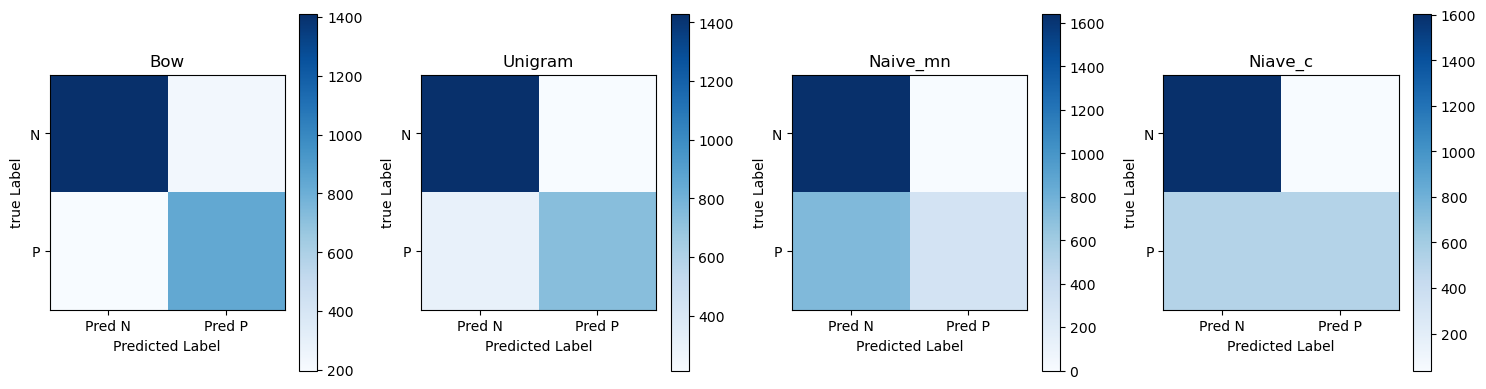

In [122]:
plot_cm(predictions_fakeNews_simple, y_test)

In [123]:
predictions_fakeNews_advanced = {"SVM":SVM_cls_pred,"MNnb":MNnb_pred_int, "Passive aggresive":PAC_pred, "Perceptron":pct_pred}

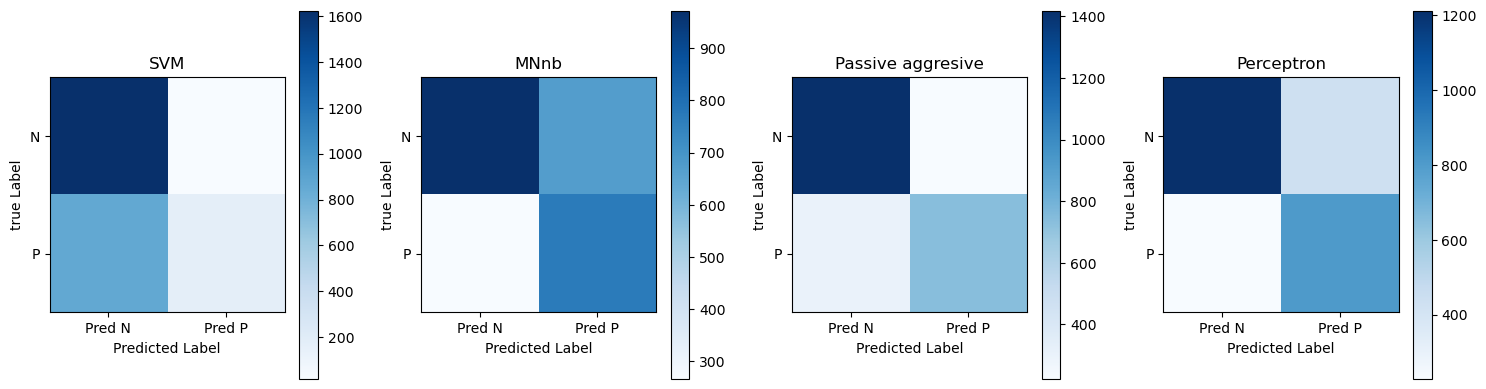

In [124]:
plot_cm(predictions_fakeNews_advanced, y_test)

### Now we try our models on the Liar Data set
First we read and clean the Liar data set 

We have decided to use the train data set because it is the biggest dataset and since we dont have to actually train a new model we just want as much data as possible to test on. 

In [125]:
liar_dataset = pd.read_table("liar_dataset/train.tsv", names=["ID", "label","content","subjects", "speaker", "speaker job title", "state info", "party affli", "barely true counts", "false counts", "half true counts", "mostly true counts", "pants on fire counts", "location"]  )

In [126]:
ld, liar_news_file = clean_file(liar_dataset)

In [127]:
ld["content"] = ld["content"].apply(tokenize)
ld["content"] = ld["content"].apply(removing_stopwords)
ld["content"] = ld["content"].apply(stemming)

ld["content"] = ld["content"].apply(" ".join)

### Then we label the classes. 
Here we have chosen to represent half-true, mostly-true and true as the true articles and the rest as false articles. 

In [128]:
true_list = ["half-true", "mostly-true", "true"]

In [129]:
ld["label"].value_counts()

half-true      2114
false          1995
mostly-true    1962
true           1676
barely-true    1654
pants-fire      839
Name: label, dtype: int64

In [130]:
## Transforming the labels
ld["label"] = ld["label"].isin(true_list)

In [131]:
y_ld = ld["label"]

### We then make the different feature sets for the different models. 

In [132]:
ld_bow = bow_vectorizer.transform(ld["content"])
ld_unigram = unigram_vectorizer.transform(ld["content"])
ld_ngram = tfidf_vect_ngram.transform(ld["content"])
ld_hash = hashingvectorizer.fit_transform(ld["content"])

### Now we measure our performance of our models trained on only 50000 rows on the Liar dataset. 

In [133]:
ld_bow_pred = bow_lreg.predict_proba(ld_bow) 
ld_bow_pred_int = ld_bow_pred[:,1] >= 0.5 # Setting a threshold of 0.5

print(f"BoW Log \n Accuracy score: {accuracy_score(y_ld, ld_bow_pred_int):.4f} \n f1_score:{f1_score(y_ld, ld_bow_pred_int):.4f}")

ld_unigram_pred = tf_lreg.predict_proba(ld_unigram)
ld_unigram_pred_int = ld_unigram_pred[:,1] >= 0.5

print(f"Unigram Log \n Accuracy score: {accuracy_score(y_ld, ld_unigram_pred_int):.4f} \n f1_score:{f1_score(y_ld, ld_unigram_pred_int):.4f}")

ld_naive_mn_pred = tfidf_bigram_naive_MN.predict_proba(ld_ngram)
ld_naive_mn_pred_int = ld_naive_mn_pred[:,1] >= 0.5

print(f"Naive Bayes Multinomial \n Accuracy score: {accuracy_score(y_ld, ld_naive_mn_pred_int):.4f} \n f1_score:{f1_score(y_ld, ld_naive_mn_pred_int):.4f}")    


ld_naive_c_pred = tfidf_bigram_naive_C.predict_proba(ld_ngram)
ld_naive_c_pred_int = ld_naive_c_pred[:,1] >= 0.5

print(f"Naive Bayes Complement \n Accuracy score: {accuracy_score(y_ld, ld_naive_c_pred_int):.4f} \n f1_score:{f1_score(y_ld, ld_naive_c_pred_int):.4f}")     

BoW Log 
 Accuracy score: 0.5497 
 f1_score:0.6911
Unigram Log 
 Accuracy score: 0.5301 
 f1_score:0.6346
Naive Bayes Multinomial 
 Accuracy score: 0.4387 
 f1_score:0.0090
Naive Bayes Complement 
 Accuracy score: 0.4396 
 f1_score:0.1952


### Now we measure our performance of our models trained with out of core method on  Liar dataset. 

In [134]:
ld_SVM_cls_pred = SVM.predict(ld_hash) 
print(f"SVM \n Accuracy score: {accuracy_score(y_ld, ld_SVM_cls_pred):.4f} \n f1_score:{f1_score(y_ld, ld_SVM_cls_pred):.4f}")

ld_MNnb_pred = MNnb.predict_proba(ld_hash)
ld_MNnb_pred_int = ld_MNnb_pred[:,1] >= 0.5
print(f"MNnb Log \n Accuracy score: {accuracy_score(y_ld, ld_MNnb_pred_int):.4f} \n f1_score:{f1_score(y_ld, ld_MNnb_pred_int):.4f}")


ld_PAC_pred = PAC.predict(ld_hash)
print(f"Passive Aggressive cls \n Accuracy score: {accuracy_score(y_ld, ld_PAC_pred):.4f} \n f1_score:{f1_score(y_ld, ld_PAC_pred):.4f}")     

ld_pct_pred =pct.predict(ld_hash)
print(f"Perceptron \n Accuracy score: {accuracy_score(y_ld, ld_pct_pred):.4f} \n f1_score:{f1_score(y_ld, ld_pct_pred):.4f}")   

SVM 
 Accuracy score: 0.4602 
 f1_score:0.2018
MNnb Log 
 Accuracy score: 0.5486 
 f1_score:0.6894
Passive Aggressive cls 
 Accuracy score: 0.5039 
 f1_score:0.4964
Perceptron 
 Accuracy score: 0.5235 
 f1_score:0.5627


### Then we make the confusion matrix for the ld dataset trained on our models. 

In [135]:
ld_predictions_simple = {"Bow":ld_bow_pred_int,"Unigram":ld_unigram_pred_int, "Naive_mn":ld_naive_mn_pred_int, "Niave_c":ld_naive_c_pred_int}

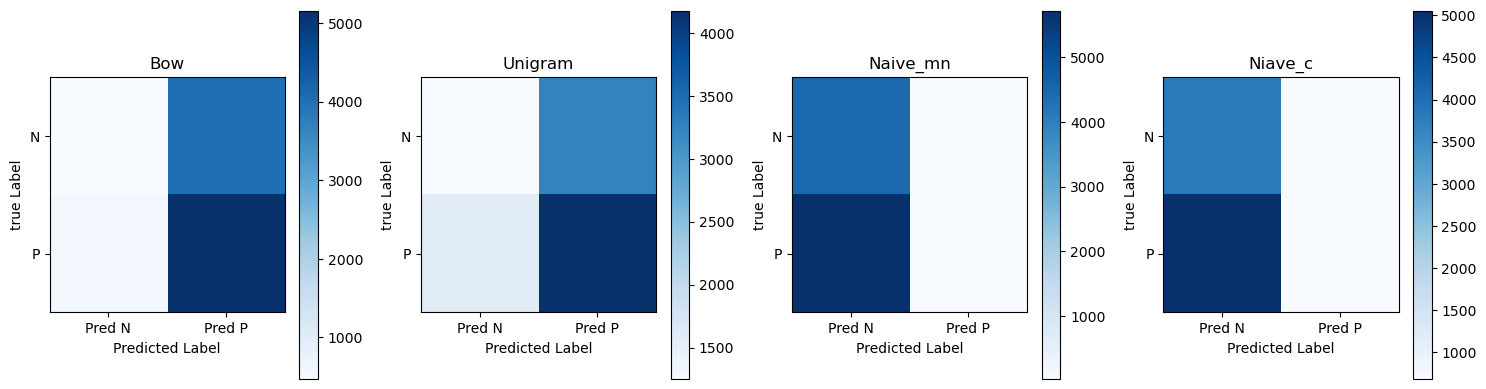

In [136]:
plot_cm(ld_predictions_simple, y_ld)

We can see that our models are terrible and it mainly just thinks that every article is true. 

In [137]:
ld_predictions_advanced = {"SVM":ld_SVM_cls_pred,"MNnb":ld_MNnb_pred_int, "Passive aggresive":ld_PAC_pred, "Perceptron":ld_pct_pred}

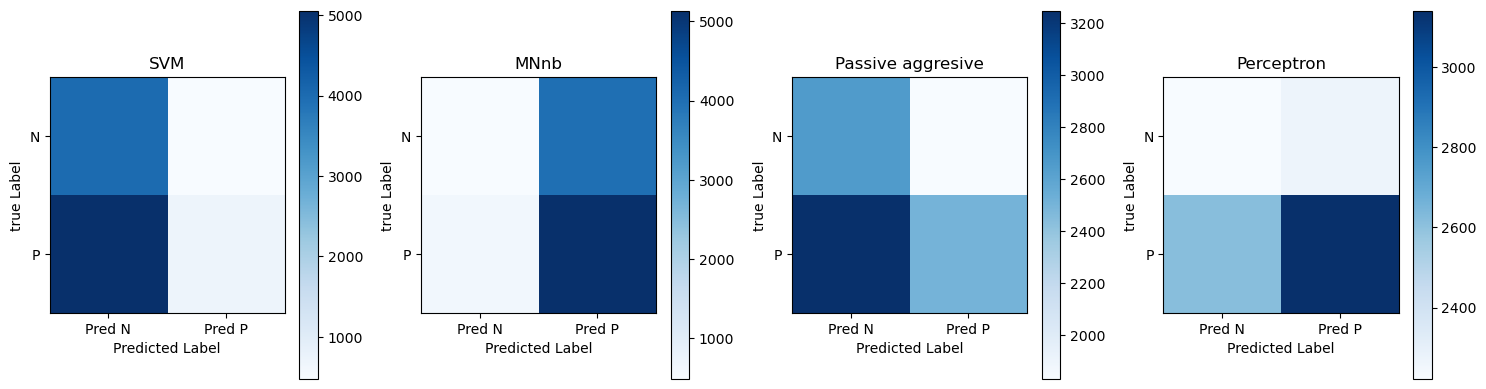

In [138]:
plot_cm(ld_predictions_advanced, y_ld)

### Trying out the model on completely different data from the data set.

### We start by preprocessing

In [139]:
df1 = pd.read_csv("news_cleaned_2018_02_13.csv", nrows=10000, skiprows=lambda x: x in range(1, 500000),usecols=["type", "content"])

In [140]:
df1, _ = clean_file(df1)

In [141]:
a = ['rumor', 'hate', 'unreliable', 'conspiracy', 'clickbait', 'satire',
       'fake', 'reliable', 'bias', 'political', 'junksci']

df1 = df1[df1["type"].isin(a)]

In [142]:
df1.drop_duplicates("content",inplace=True) 

In [143]:
df1_labels = df1["type"].isin(["political", "reliable" , "clickbait"])

In [144]:
df1.insert(loc = len(df1.columns) , column = "label" ,value = df1_labels)     

In [145]:
df1["content"] = df1["content"].apply(tokenize)
df1["content"] = df1["content"].apply(removing_stopwords)
df1["content"] = df1["content"].apply(stemming)
df1["content"] = df1["content"].apply(" ".join)

In [146]:
new_test = df1["label"]

## Then we make the feature sets 

In [147]:
df1_bow = bow_vectorizer.transform(df1["content"])
df1_unigram = unigram_vectorizer.transform(df1["content"])
df1_ngram = tfidf_vect_ngram.transform(df1["content"])
df1_hash = hashingvectorizer.fit_transform(df1["content"])

## We test the performance

In [148]:
new_lreg_bow_pred = bow_lreg.predict_proba(df1_bow) 
new_lreg_bow_pred_int = new_lreg_bow_pred[:,1] >= 0.5 # Setting a threshold of 0.5

print(f"BoW Log \n Accuracy score: {accuracy_score(new_test, new_lreg_bow_pred_int):.4f} \n f1_score:{f1_score(new_test, new_lreg_bow_pred_int):.4f}")

new_unigram_pred = tf_lreg.predict_proba(df1_unigram)
new_unigram_pred_int = new_unigram_pred[:,1] >= 0.5

print(f"Unigram Log \n Accuracy score: {accuracy_score(new_test, new_unigram_pred_int):.4f} \n f1_score:{f1_score(new_test, new_unigram_pred_int):.4f}")

new_naive_mn_pred = tfidf_bigram_naive_MN.predict_proba(df1_ngram)
new_naive_mn_pred_int = new_naive_mn_pred[:,1] >= 0.5

print(f"Naive Bayes Multinomial \n Accuracy score: {accuracy_score(new_test, new_naive_mn_pred_int):.4f} \n f1_score:{f1_score(new_test, new_naive_mn_pred_int):.4f}")    


new_naive_c_pred = tfidf_bigram_naive_C.predict_proba(df1_ngram)
new_naive_c_pred_int = new_naive_c_pred[:,1] >= 0.5

print(f"Naive Bayes Complement \n Accuracy score: {accuracy_score(new_test, new_naive_c_pred_int):.4f} \n f1_score:{f1_score(new_test, new_naive_c_pred_int):.4f}")     





BoW Log 
 Accuracy score: 0.4865 
 f1_score:0.3702
Unigram Log 
 Accuracy score: 0.4149 
 f1_score:0.3150
Naive Bayes Multinomial 
 Accuracy score: 0.7324 
 f1_score:0.0683
Naive Bayes Complement 
 Accuracy score: 0.7059 
 f1_score:0.1605


In [149]:
new_SVM_cls_pred = SVM.predict(df1_hash) 
print(f"SVM \n Accuracy score: {accuracy_score(new_test, new_SVM_cls_pred):.4f} \n f1_score:{f1_score(new_test, new_SVM_cls_pred):.4f}")

new_MNnb_pred = MNnb.predict_proba(df1_hash)
new_MNnb_pred_int = new_MNnb_pred[:,1] >= 0.5
print(f"MNnb Log \n Accuracy score: {accuracy_score(new_test, new_MNnb_pred_int):.4f} \n f1_score:{f1_score(new_test, new_MNnb_pred_int):.4f}")  

new_PAC_pred = PAC.predict(df1_hash)
print(f"Passive Aggressive cls \n Accuracy score: {accuracy_score(new_test, new_PAC_pred):.4f} \n f1_score:{f1_score(new_test, new_PAC_pred):.4f}")     

new_pct_pred =pct.predict(df1_hash)
print(f"Perceptron \n Accuracy score: {accuracy_score(new_test, new_pct_pred):.4f} \n f1_score:{f1_score(new_test, new_pct_pred):.4f}")   

SVM 
 Accuracy score: 0.7590 
 f1_score:0.2674
MNnb Log 
 Accuracy score: 0.7072 
 f1_score:0.6262
Passive Aggressive cls 
 Accuracy score: 0.7659 
 f1_score:0.6391
Perceptron 
 Accuracy score: 0.6381 
 f1_score:0.5485


## We make the confusion matrix

In [150]:
new_predictions_simple = {"Bow":new_lreg_bow_pred_int,"Unigram":new_unigram_pred_int, "Naive_mn":new_naive_mn_pred_int, "Niave_c":new_naive_c_pred_int}

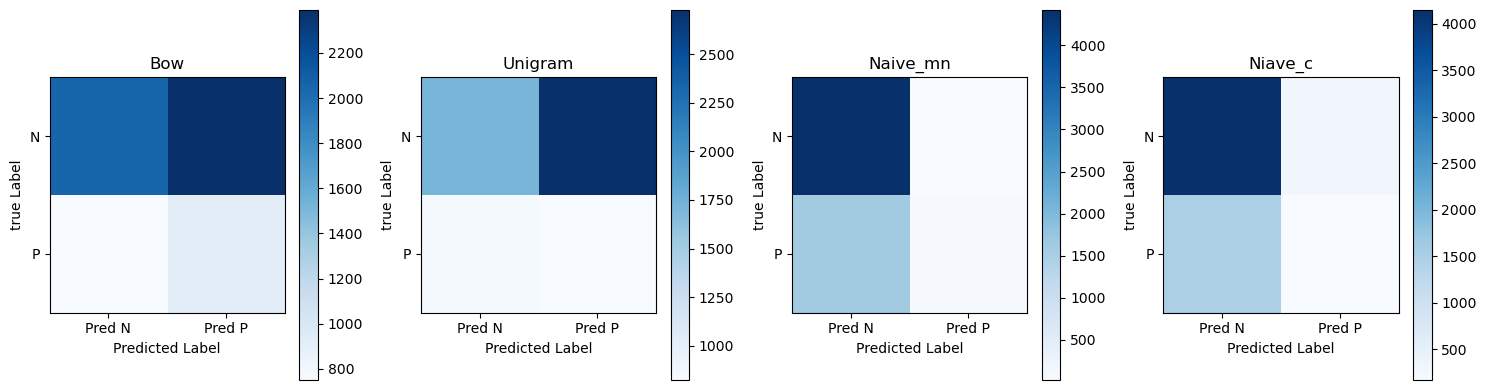

In [151]:
plot_cm(new_predictions_simple, new_test)

In [152]:
new_predictions_advanced = {"SVM":new_SVM_cls_pred,"MNnb":new_MNnb_pred_int, "Passive aggresive":new_PAC_pred, "Perceptron":new_pct_pred}

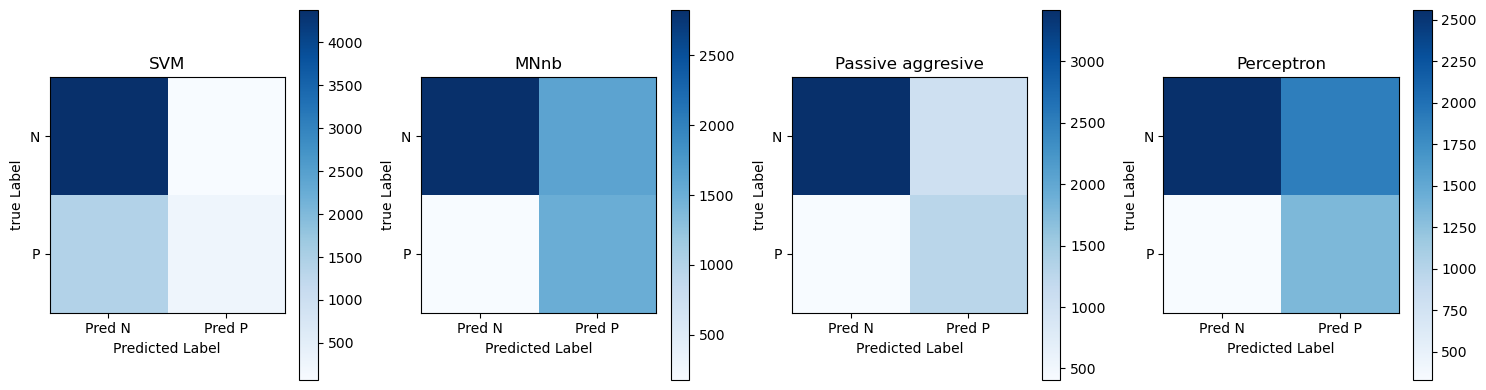

In [153]:
plot_cm(new_predictions_advanced, new_test)
